Выполнила:

Балжан Досмухаметова  

telegram: @dosbalzhan

## Задача:

В архиве во вложении данные по выдачам кредитов и платежам: плановым и
фактическим. Данные актуальны на 08.12.2022. Проанализируйте характер поведения
клиентов с точки зрения просрочки: какая динамика просрочки, наблюдается ли рост или
снижение?


order_id – номер заявки

created_at - дата создания заявки

put_at - дата выдачи

closed_at - дата закрытия

issued_sum - сумма выдачи

plan_at - дата планового платежа

plan_sum_total - сумма планового платежа (накопленным итогом)

paid_at - дата фактического платежа

paid_sum - сумма фактического платежа

## 1. Подготовка данных

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
orders = pd.read_csv("dataset/orders.csv")
payments = pd.read_csv("dataset/payments.csv")
plan = pd.read_csv ("dataset/plan.csv")


print(orders.head(3))
print(payments.head(3))
print(plan.head(3))


    order_id               created_at                   put_at  \
0  400001732  2022-06-02 00:00:23.997  2022-06-02 20:18:00.180   
1  400005838  2022-06-02 00:10:22.997  2022-06-02 15:41:33.267   
2  400007915  2022-06-02 00:18:04.000  2022-06-05 19:17:38.547   

                 closed_at  issued_sum  
0  2022-10-17 11:52:22.190     13600.0  
1  2022-06-02 17:38:43.917     20000.0  
2  2022-06-21 21:55:51.877      5820.0  
    order_id                  paid_at  paid_sum
0  400013633  2022-06-02 00:48:13.800    2500.0
1  400018480  2022-06-02 01:52:05.707    1070.0
2  400032001  2022-06-02 04:55:40.307    4200.0
    order_id     plan_at  plan_sum_total
0  400001732  2022-06-02          5600.0
1  400001732  2022-07-02          9450.0
2  400001732  2022-08-01         12170.0


##  1.1. Проверка дубликатов и пропусков


In [6]:
print(orders.isnull().sum())
print(payments.isnull().sum())
print(plan.isnull().sum())

print(f"Дубликатов в orders: {orders.duplicated().sum()}")
print(f"Дубликатов в payments: {payments.duplicated().sum()}")
print(f"Дубликатов в plan: {plan.duplicated().sum()}")

order_id         0
created_at       0
put_at           0
closed_at     9276
issued_sum       0
dtype: int64
order_id    0
paid_at     0
paid_sum    0
dtype: int64
order_id          0
plan_at           0
plan_sum_total    0
dtype: int64
Дубликатов в orders: 0
Дубликатов в payments: 5
Дубликатов в plan: 0


В результате видим что есть пропуски в closed_at:

Проверяем отношение пропусков к статусу кредита


Пропуски могут означать что кредит полностью еще не закрыли, статус активен.

Создадим флаг is_active для незакрытых кредитов


In [7]:
orders["is_active"] = orders["closed_at"].isna()

status_counts = orders["is_active"].value_counts()
print(status_counts)

print(f"Доля активных кредитов: {status_counts[True] / orders.shape[0]:.2%}")


is_active
False    46472
True      9276
Name: count, dtype: int64
Доля активных кредитов: 16.64%


Также в таблице payments есть дубликаты, уточним:

Это могут быть повторные платежи по одному кредиту или ошибки в данных.

In [8]:
duplicates = payments[payments.duplicated()]
print(duplicates)

         order_id                  paid_at  paid_sum
11475   411504997  2022-06-24 17:14:56.997   10100.0
12470   422632789  2022-06-25 23:16:16.000    8080.0
37759   432761640  2022-07-21 12:38:12.000     150.0
38414   420036980  2022-07-21 20:08:58.997    4800.0
139590  456075017  2022-11-22 19:44:08.793    2720.0


Проверяем дубликаты по order_id and paid_at но с разными суммами. Если у одного order_id на одну и ту же paid_at разные paid_sum, то возможно клиент платил частями.


In [9]:
potential_duplicates = payments[payments.duplicated(subset=['order_id', 'paid_at'], keep=False)]
print(potential_duplicates.sort_values(by=['order_id', 'paid_at']))


         order_id                  paid_at  paid_sum
943     401467534  2022-06-06 00:00:00.000   10600.0
944     401467534  2022-06-06 00:00:00.000   10000.0
11474   411504997  2022-06-24 17:14:56.997   10100.0
11475   411504997  2022-06-24 17:14:56.997   10100.0
38413   420036980  2022-07-21 20:08:58.997    4800.0
38414   420036980  2022-07-21 20:08:58.997    4800.0
12469   422632789  2022-06-25 23:16:16.000    8080.0
12470   422632789  2022-06-25 23:16:16.000    8080.0
37758   432761640  2022-07-21 12:38:12.000     150.0
37759   432761640  2022-07-21 12:38:12.000     150.0
107137  456032155  2022-09-15 14:23:59.997    1600.0
107138  456032155  2022-09-15 14:23:59.997    1000.0
139589  456075017  2022-11-22 19:44:08.793    2720.0
139590  456075017  2022-11-22 19:44:08.793    2720.0



В итоге мы убделись что эти 5 дубликатов - реальные. Получается нам можно их удалить


In [10]:
payments = payments.drop_duplicates()

## 1.2. Объединение таблиц

Мердж orders + plan по order_id

Добавление платежей (payments) с обработкой дубликатов

In [11]:
df = orders.merge(plan, on="order_id", how="left").merge(payments, on="order_id", how="left")


df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483565 entries, 0 to 1483564
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   order_id        1483565 non-null  int64  
 1   created_at      1483565 non-null  object 
 2   put_at          1483565 non-null  object 
 3   closed_at       1128772 non-null  object 
 4   issued_sum      1483565 non-null  float64
 5   is_active       1483565 non-null  bool   
 6   plan_at         1483565 non-null  object 
 7   plan_sum_total  1483565 non-null  float64
 8   paid_at         1466193 non-null  object 
 9   paid_sum        1466193 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 103.3+ MB


## 1.3. Преобразование типов данных

Нужно преобразовать колонки которые имеют object type в datatime, чтобы выполнить ариф.операции. Мы о них узнали при проверке структуры данных после объединения таблиц.

In [12]:
df["created_at"] = pd.to_datetime(df["created_at"])
df["put_at"] = pd.to_datetime(df["put_at"])
df["closed_at"] = pd.to_datetime(df["closed_at"], errors="coerce")
df["plan_at"] = pd.to_datetime(df["plan_at"], errors = "coerce")
df["paid_at"] = pd.to_datetime(df["paid_at"], errors="coerce")

## 2. Анализ кредитного портфеля

### 2.1. Общая статистика по кредитам


  
Сколько кредитов было выдано?

In [13]:
total_loans = df['order_id'].nunique()
print (f"Количество выданных кредитов: {total_loans}")

Количество выданных кредитов: 55748


Общая и средняя сумма кредита?

In [14]:
total_sum = df["issued_sum"].sum()
print(f"Общая сумма кредита: {total_sum:,.2f}")

avg_issued_sum = df["issued_sum"].mean()
print(f"Средняя сумма кредита: {avg_issued_sum:.2f}")

Общая сумма кредита: 13,727,600,960.00
Средняя сумма кредита: 9253.12


Какая доля активных кредитов?

In [15]:
active_ratio = orders["is_active"].mean()
print(f"Доля активных кредитов: {active_ratio:.2%}")

Доля активных кредитов: 16.64%


### 2.2 Расчет дней просрочки платежей

Актуальная дата:  2022-12-08

Фиксируем дату, на которую проверяется просрочка

Выявим все просроченные платежи (включая непогашенные)

Определим длительность задержки (в днях)




In [16]:
df = df.sort_values(['order_id', 'plan_at'])
current_date = pd.to_datetime('2022-12-08')

#Если платеж не внесен, считаются дни от plan_at до current_date.

#Если платеж внесен, вычисляется разница между фактической и плановой датами.

df["days_late"] = np.where(
    df["paid_at"].isna(),
    (current_date - df["plan_at"]).dt.days,
    (df["paid_at"] - df["plan_at"]).dt.days
)

# True, если есть задержка или платеж отсутствует, а срок прошел
df["is_late"] = (df["days_late"] > 0) | (df["paid_at"].isna() & (df["plan_at"] < current_date))



pd.set_option('display.float_format', '{:.2f}'.format)
df[["order_id", "plan_at", "paid_at", "days_late", "is_late"]].head()


,order_id,plan_at,paid_at,days_late,is_late
0,400001732,2022-06-02,2022-06-02 20:20:16.790,0.00,False
1,400001732,2022-06-02,2022-06-16 16:05:26.007,14.00,True
2,400001732,2022-06-02,2022-07-15 12:32:34.087,43.00,True
3,400001732,2022-06-02,2022-08-16 12:38:01.237,75.00,True
4,400001732,2022-06-02,2022-09-15 12:14:48.867,105.00,True


Сколько средняя и максимальная просрочка дней?

In [17]:
print(f"Средняя просрочка (дней): {df['days_late'].mean():.2f}")
print(f"Максимальная просрочка (дней): {df['days_late'].max()}")

Средняя просрочка (дней): -48.98
Максимальная просрочка (дней): 189.0



Сколько платежей было просрочено?


In [18]:
late_payments_count = df["is_late"].sum()
total_payments = len(df)
print(f"Просроченные платежи: {late_payments_count} из {total_payments} ({late_payments_count / total_payments:.2%})")


Просроченные платежи: 333458 из 1483565 (22.48%)


## 3. Расчет суммы просрочки

paid_sum—это сумма фактического платежа за один день.

plan_sum_total — это накопленный плановый платёж.

Если просто вычесть paid_sum, результат может быть некорректным.

Поэтому нужно вычислить разницу между текущим plan_sum_total и предыдущим plan_sum_total для данного order_id.

Plan_sum будет плановый платёж за каждый месяц

In [19]:
df['plan_sum'] = df['plan_sum_total'] - df.groupby('order_id')['plan_sum_total'].shift(1).fillna(0)

# Напишем условие просрочки:

# - Платеж отсутствует и plan_at прошла
# - Платеж внесен позже plan_at
# - Платеж внесен (даже досрочно), но сумма меньше плановой

df['is_overdue'] = (
    (df['paid_at'].isna() & (df['plan_at'] < current_date)) |
    (df['paid_at'] > df['plan_at']) |
    ((df['paid_sum'] < df['plan_sum']) & (df['plan_sum'] > 0))  # Новое условие
)


# Если платеж просрочен, считаем разницу
df['overdue_amount'] = np.where(
    df['is_overdue'],
    df['plan_sum'] - df['paid_sum'].fillna(0),0) # иначе 0, нет просрочки


Я решила обнулить отрицательных значений.
 Зачем нужно?

Если клиент внес больше чем должен был, то overdue_amount дает отрицательное число. Просрочка не может быть отрицательной. Поэтому заменяем наши значения на 0

In [20]:
df.loc[df['overdue_amount'] < 0, 'overdue_amount'] = 0

# Итоговая сумма
total_overdue = df['overdue_amount'].sum()
print(f"Сумма просрочки: {total_overdue:,.2f}")

Сумма просрочки: 61,354,329.19


In [21]:
df = df.drop_duplicates(subset=['order_id', 'plan_at'])
df[['order_id','paid_at', 'plan_at', 'plan_sum_total', 'plan_sum']].head(10)


,order_id,paid_at,plan_at,plan_sum_total,plan_sum
0,400001732,2022-06-02 20:20:16.790,2022-06-02,5600.00,5600.00
7,400001732,2022-06-02 20:20:16.790,2022-07-02,9450.00,3850.00
14,400001732,2022-06-02 20:20:16.790,2022-08-01,12170.00,2720.00
21,400001732,2022-06-02 20:20:16.790,2022-08-31,14890.00,2720.00
28,400001732,2022-06-02 20:20:16.790,2022-09-30,17610.00,2720.00
35,400001732,2022-06-02 20:20:16.790,2022-10-30,20330.00,2720.00
42,400001732,2022-06-02 20:20:16.790,2022-11-29,23050.00,2720.00
49,400005838,2022-06-02 17:38:43.917,2022-06-17,23000.00,23000.00
50,400007915,2022-06-05 19:18:12.457,2022-06-05,1820.00,1820.00
52,400007915,2022-06-05 19:18:12.457,2022-06-20,2730.00,910.00


## Динамика просрочки по месяцам


<Axes: title={'center': 'Динамика просрочки по месяцам'}, xlabel='month'>

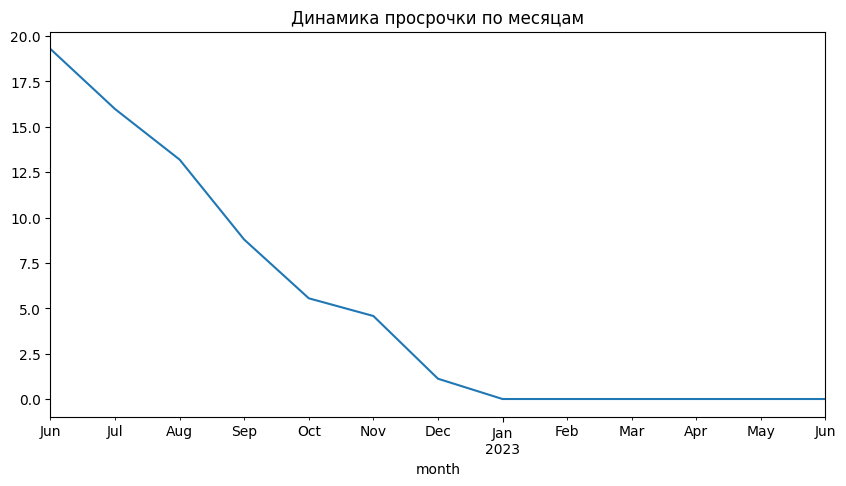

In [22]:
df["month"] = df["plan_at"].dt.to_period("M")
late_trend = df.groupby("month")["is_late"].mean() * 100
late_trend.plot(kind="line", title="Динамика просрочки по месяцам", figsize=(10,5))


По динамику просрочки можно сделать такие выводы:

- Снижение просрочек: На графике видно, что с Июня по Декабрь количество просрочек сильно снижается, а с января 2023 года почти отсутствует.
- Устранение задолженностей: Судя по графику, к декабрю все долги были погашены или новые просрочки не возникали
- Эффективные меры: Возможно, сработали какие-то меры по снижению задолженностей:
   
  Изменение политики кредитования / Улучшение работы с клиентами / Более строгий контроль за платежами


В целом, график показывает позитивную динамику – просрочки почти исчезли.

Есть ли клиенты, которые чаще всех задерживают платежи?

In [23]:
late_clients = df[df["is_late"]].groupby("order_id")["is_late"].sum().reset_index()
late_clients.columns = ["order_id", "late_count"]
late_clients = late_clients.sort_values(by="late_count", ascending=False)
print(late_clients.head(10))  # ТОП-10 самых проблемных клиентов


      order_id  late_count
25   400161627          13
11   400087077          13
839  407063935          13
771  406388278          13
788  406562452          13
432  403570788          13
419  403393201          13
72   400489217          13
464  403751549          13
102  400751408          13


Для этих клиентов:

-Можно ужесточить условия для этих клиентов (например, снизить доступный кредитный лимит).

-Разработать стратегию напоминаний (SMS, email, звонки).

-Разобраться, почему они задерживают платежи


### Как просрочки зависят от суммы кредита?



Практически по всем суммам кредита есть и те, кто платит вовремя, и те, кто задерживает. Это говорит о том, что просрочка не сильно зависит от суммы кредита.


<Axes: xlabel='issued_sum', ylabel='days_late'>

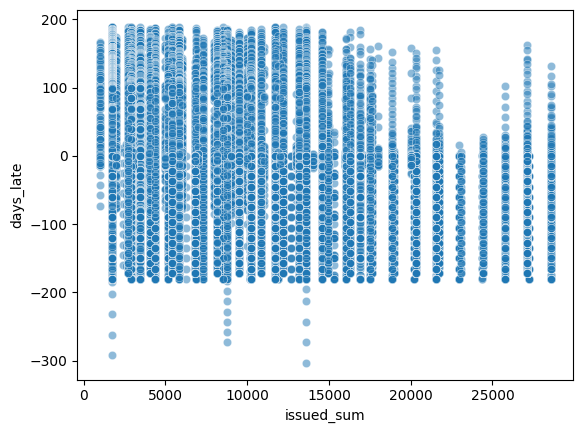

In [24]:
sns.scatterplot(data=df, x="issued_sum", y="days_late", alpha=0.5)

<Axes: xlabel='is_late', ylabel='issued_sum'>

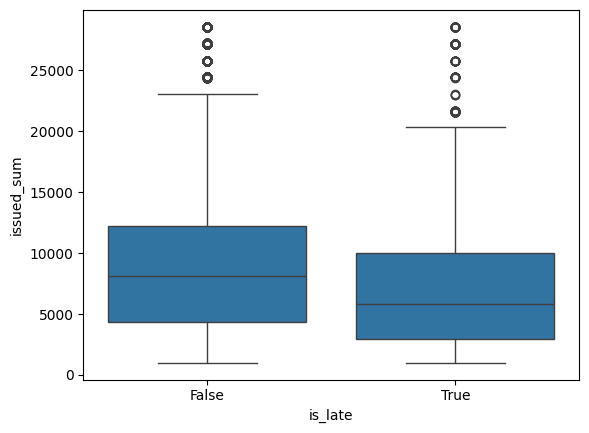

In [25]:
sns.boxplot(x=df["is_late"], y=df["issued_sum"])


In [26]:
print(df.columns)

Index(['order_id', 'created_at', 'put_at', 'closed_at', 'issued_sum',
       'is_active', 'plan_at', 'plan_sum_total', 'paid_at', 'paid_sum',
       'days_late', 'is_late', 'plan_sum', 'is_overdue', 'overdue_amount',
       'month'],
      dtype='object')


In [27]:
df.head(3)

,order_id,created_at,put_at,closed_at,issued_sum,is_active,plan_at,plan_sum_total,paid_at,paid_sum,days_late,is_late,plan_sum,is_overdue,overdue_amount,month
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.00,False,2022-06-02,5600.00,2022-06-02 20:20:16.790,5600.00,0.00,False,5600.00,True,0.00,2022-06
7,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.00,False,2022-07-02,9450.00,2022-06-02 20:20:16.790,5600.00,-30.00,False,3850.00,False,0.00,2022-07
14,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.00,False,2022-08-01,12170.00,2022-06-02 20:20:16.790,5600.00,-60.00,False,2720.00,False,0.00,2022-08


In [28]:
df.to_csv("final_overdue_data.csv", index = False)